# Predicting Video Game Sales
First of all, we need to import some libraries.

In [15]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Allows the use of display() for DataFrames
from IPython.display import display

# make pretty
plt.style.use('ggplot')

# Pretty display for notebooks
%matplotlib inline

# Data Schema

## Dataset 1 (Video_Games_Sales_as_at_22_Dec_2016.csv)
This is my main dataset. It will be used to predict video game sales.

| title           | description                                                   | data type |
|-----------------|---------------------------------------------------------------|-----------|
| Name            | Name of the game                                              | String    |
| Platform        | Platform                                                      | String    |
| Year_of_Release | Year of release                                               | Numeric   |
| Genre           | Genre                                                         | String    |
| Publisher       | Publisher                                                     | String    |
| NA_Sales        | Game sales in North America (in millions of units)            | Numeric   |
| EU_Sales        | Game sales in the European Union (in millions of units)       | Numeric   |
| JP_Sales        | Game sales in Japan (in millions of units)                    | Numeric   |
| Other_Sales     | Game sales in the rest of the world (in millions of units)    | Numeric   |
| Global_Sales    | Total sales in the world (in millions of units)               | Numeric   |
| Critic_Score    | Aggregate score compiled by Metacritic staff                  | Numeric   |
| Critic_Count    | The number of critics used in coming up with the Critic_score | Numeric   |
| User_Score      | Score by Metacritic's subscribers                             | Numeric   |
| User_Count      | Number of users who gave the user_score                       | Numeric   |
| Developer       | Party responsible for creating the game                       | String    |
| Rating          | The [ESRB](https://www.esrb.org/) ratings                     | String    |

## Dataset 2 (ign.csv)
This is my secondary dataset. It might be used to support the primary dataset, but this would probably require major effort for merging both.

| title           | description                                                   | data type |
|-----------------|---------------------------------------------------------------|-----------|
| ID              | ID                                                            | Numeric   |
| score_phrase    | Game rating as a phrase                                       | String    |
| title           | Name of the game                                              | String    |
| url             | URL to source of data                                         | String    |
| platform        | Platform                                                      | String    |
| score           | Game rating as a float                                        | Numeric   |
| genre           | Genre                                                         | String    |
| editors_choice  | Special recommendation of the editor                          | String    |
| release_year    | Year of release                                               | Numeric   |
| release_month   | Month of release                                              | Numeric   |
| release_day     | Day of release                                                | Numeric   |


We can remove several colums in dataset2 that we don't need:
* **ID** which is just an ID that's not used in dataset 1
* **score_phrase**, because it redundant to _score_ and less precise
* **url**, because that's just the origin of the data
The next step will be to load the datasets.

In [16]:
# Load dataset #1
try:
    dataset1 = pd.read_csv("data/Video_Games_Sales_as_at_22_Dec_2016.csv")
    print "Dataset #1 has {} samples with {} features each.".format(*dataset1.shape)
except:
    print "Dataset #1 could not be loaded. Is the dataset missing?"

print('\n')

Dataset #1 has 16719 samples with 16 features each.




In [17]:
# Display a description of the datasets
display(dataset1.dtypes)
display(dataset1.head())
display(dataset1.tail())
display(dataset1.describe())
print('\n')

Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16718,Winning Post 8 2016,PSV,2016.0,Simulation,Tecmo Koei,0.00,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN


,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,16450.000000,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.000000,8137.000000,7590.000000
mean,2006.487356,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,162.229908
std,5.878995,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,10665.000000


* Clean up all strings
* Remove rows without critic_score and user_score

In [18]:
# beautify strings
for i in range(0, len(dataset1.axes[1])):
    if (dataset1.ix[:,i].dtype == object):
        dataset1.ix[:,i] = dataset1.ix[:,i].str.strip()

## tbd to NaN
df1 = dataset1.replace('tbd', float('NaN'))

## remove rows without full relevant information
df1 = df1[df1.Platform.notnull()]
df1 = df1[df1.Genre.notnull()]
df1 = df1[df1.Publisher.notnull()]

## TODO: Hint why only global sales relevant => linear dependency and only 1688 rows otherwise
# df1 = df1[df1.NA_Sales > 0]
# df1 = df1[df1.EU_Sales > 0]
# df1 = df1[df1.JP_Sales > 0]
# df1 = df1[df1.Other_Sales > 0]
df1 = df1[df1.Global_Sales > 0]
df1 = df1[df1.Year_of_Release.notnull()]
df1 = df1[df1.Critic_Score.notnull()]
df1 = df1[df1.User_Score.notnull()]
df1 = df1[df1.Critic_Count > 0]
df1 = df1[df1.User_Count > 0]
df1 = df1[df1.Developer.notnull()]
df1 = df1[df1.Rating.notnull()]

## correct data type of User_Score
df1[['User_Score']] = df1[['User_Score']].apply(pd.to_numeric)

## Scale User_Score to boundaries of Critic_Score
df1[['User_Score']] = df1[['User_Score']] * 10

## Get new description
display(df1.describe())
display(df1.head())

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000
mean,2007.436777,0.394484,0.236089,0.064158,0.082677,0.777590,70.272088,28.931136,71.856264,174.722344
std,4.211248,0.967385,0.687330,0.287570,0.269871,1.963443,13.868572,19.224165,14.399417,587.428538
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,5.000000,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,65.000000,11.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,25.000000,75.000000,27.000000
75%,2011.000000,0.390000,0.210000,0.010000,0.070000,0.750000,80.000000,39.000000,82.000000,89.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,96.000000,10665.000000


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80.0,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83.0,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80.0,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,85.0,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,66.0,129.0,Nintendo,E


In order to understand the dataset better, we should have a look at possible values.

In [19]:
print ('DATASET 1')
for i in range(0, len(dataset1.axes[1])):
    if (df1.ix[:,i].dtype == object):
        tmp = df1.ix[:,i].unique()
        tmp.sort()
        display (tmp)

DATASET 1


array(['.hack//Infection Part 1', '.hack//Mutation Part 2',
       '.hack//Outbreak Part 3', ..., "nail'd",
       'pro evolution soccer 2011', 'uDraw Studio: Instant Artist'], dtype=object)

array(['3DS', 'DC', 'DS', 'GBA', 'GC', 'PC', 'PS', 'PS2', 'PS3', 'PS4',
       'PSP', 'PSV', 'Wii', 'WiiU', 'X360', 'XB', 'XOne'], dtype=object)

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy'], dtype=object)

array(['10TACLE Studios', '1C Company', '2D Boy', '3DO', '505 Games',
       '5pb', 'AQ Interactive', 'ASCII Entertainment',
       'Acclaim Entertainment', 'Ackkstudios', 'Acquire', 'Activision',
       'Activision Blizzard', 'Activision Value', 'Agatsuma Entertainment',
       'Agetec', 'Aksys Games', 'Alternative Software', 'Aqua Plus',
       'Arc System Works', 'Ascaron Entertainment GmbH', 'Aspyr', 'Atari',
       'Atlus', 'Avalon Interactive', 'Avanquest', 'BAM! Entertainment',
       'Banpresto', 'Bethesda Softworks', 'Bigben Interactive',
       'Black Bean Games', 'Black Label Games', 'Blue Byte',
       'Bohemia Interactive', 'Brash Entertainment', 'CCP',
       'CDV Software Entertainment', 'Capcom', 'Cave', 'City Interactive',
       'Cloud Imperium Games Corporation', 'Codemasters',
       'Codemasters Online', 'Compile Heart', 'Conspiracy Entertainment',
       'Crave Entertainment', 'Crimson Cow', 'D3Publisher',
       'DHM Interactive', 'DSI Games', 'DTP Entertainment'

array(['10tacle Studios, Fusionsphere Systems', '1C, 1C Company',
       '1C, Ino-Co, 1C Company', ..., 'odenis studio', 'syn Sophia',
       'zSlide'], dtype=object)

array(['AO', 'E', 'E10+', 'K-A', 'M', 'RP', 'T'], dtype=object)

In [20]:
# stats
print('MEDIAN')
display(df1.median())
print('STANDARD DEVIATION')
display(df1.std())

# TODO: Remove data before 1999, because metacritic was founded on July 16, 1999,
#       so there are hardly and rows for this time - considered outliers
#       (https://en.wikipedia.org/wiki/Metacritic)

# TODO: Check for outliers, see below visually

MEDIAN


Year_of_Release    2007.00
NA_Sales              0.15
EU_Sales              0.06
JP_Sales              0.00
Other_Sales           0.02
Global_Sales          0.29
Critic_Score         72.00
Critic_Count         25.00
User_Score           75.00
User_Count           27.00
dtype: float64

STANDARD DEVIATION


Year_of_Release      4.211248
NA_Sales             0.967385
EU_Sales             0.687330
JP_Sales             0.287570
Other_Sales          0.269871
Global_Sales         1.963443
Critic_Score        13.868572
Critic_Count        19.224165
User_Score          14.399417
User_Count         587.428538
dtype: float64

In [21]:
# We can create some new features as aggregates from the others

# Platform manufacturer based on the platform
man_microsoft = ['PC','X360','XB','XOne']
man_nintendo  = ['3DS','DS','GBA','GC','N64','Wii','WiiU']
man_sega      = ['DC']
man_sony      = ['PS','PS2','PS3','PS4' ,'PSP','PSV']

df1['Platform_Manufacturer'] = df1['Platform'].map(lambda x:
    'Microsoft' if x in man_microsoft else
    'Nintendo' if x in man_nintendo else
    'Sega' if x in man_sega else
    'Sony' if x in man_sony else
    float('NaN'))


# Portable based on the platform
portables = ['3DS','DS','GBA','PSP','PSV']

df1['Portable'] = df1['Platform'].map(lambda x: True if x in portables else False)


# Genres (Boolean)
for genre in df1['Genre'].unique():
    df1['Genre_' + genre] = df1['Genre'].map(lambda x: True if x == genre else False)

    
# Rating (Boolean)
for rating in df1['Rating'].unique():
    df1['Rating_' + rating] = df1['Rating'].map(lambda x: True if x == rating else False)

Also, Plots will probably help ...

In [22]:
# Are there high correlations?
df1.corr()
# df1.corr()[df1.corr() > 0.7]

# NA_Sales with EU_Sales and yet Other_Sales => Global_Sales
# Critic_Score and User_Score only 0.580318, had not expected that

# No other correlations, also not for booleans


,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,...,Genre_Role-Playing,Genre_Adventure,Genre_Strategy,Rating_E,Rating_M,Rating_T,Rating_E10+,Rating_AO,Rating_K-A,Rating_RP
Year_of_Release,1.000000,-0.016239,0.041346,-0.038443,0.042315,0.006661,-0.007661,0.203336,-0.253914,0.199348,...,0.028687,0.009052,-0.031159,-0.173387,0.156777,-0.084662,0.165198,-0.007005,-0.032878,0.010243
NA_Sales,-0.016239,1.000000,0.841808,0.468607,0.726757,0.955793,0.233580,0.283917,0.085796,0.246208,...,-0.030397,-0.047776,-0.056310,0.054184,0.059250,-0.077422,-0.035692,0.010831,-0.001683,-0.004937
EU_Sales,0.041346,0.841808,1.000000,0.519929,0.716330,0.939313,0.213102,0.265740,0.055915,0.283504,...,-0.034101,-0.038154,-0.041592,0.045951,0.067395,-0.073594,-0.039536,0.006586,-0.001340,-0.003630
JP_Sales,-0.038443,0.468607,0.519929,1.000000,0.394823,0.613546,0.147314,0.168299,0.127521,0.072773,...,0.128004,-0.019555,-0.033614,0.063183,-0.037106,-0.008390,-0.030979,-0.002701,0.058763,-0.002701
Other_Sales,0.042315,0.726757,0.716330,0.394823,1.000000,0.804028,0.191509,0.239513,0.057083,0.240085,...,-0.032872,-0.036136,-0.043309,0.023180,0.071009,-0.063266,-0.027364,0.000329,-0.002363,-0.003260
Global_Sales,0.006661,0.955793,0.939313,0.613546,0.804028,1.000000,0.237556,0.290397,0.088349,0.264151,...,-0.012762,-0.044704,-0.053122,0.055200,0.057078,-0.073781,-0.039724,0.007229,0.007044,-0.004610
Critic_Score,-0.007661,0.233580,0.213102,0.147314,0.191509,0.237556,1.000000,0.396478,0.580318,0.265639,...,0.062710,-0.057958,0.041490,0.019448,0.062912,-0.031220,-0.058578,0.019840,0.018967,-0.006348
Critic_Count,0.203336,0.283917,0.265740,0.168299,0.239513,0.290397,0.396478,1.000000,0.195087,0.365603,...,0.072987,-0.040241,0.005283,-0.209823,0.275551,0.027961,-0.084316,0.018306,-0.008773,-0.010662
User_Score,-0.253914,0.085796,0.055915,0.127521,0.057083,0.088349,0.580318,0.195087,1.000000,0.017546,...,0.102613,-0.003336,0.023429,-0.011045,-0.003224,0.069283,-0.077932,0.011891,0.001802,-0.003242
User_Count,0.199348,0.246208,0.283504,0.072773,0.240085,0.264151,0.265639,0.365603,0.017546,1.000000,...,0.090922,-0.019820,0.014901,-0.131970,0.285410,-0.073690,-0.059140,-0.001169,-0.002612,-0.003044


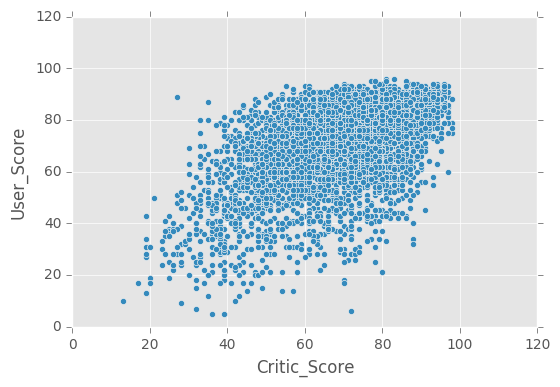

In [23]:
# Critic_Score and User_Score
df1.plot.scatter(x='Critic_Score', y='User_Score')

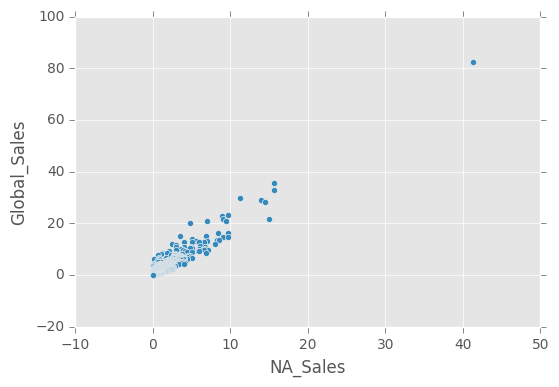

In [24]:
# NA_Sales and Global_Sales
df1.plot.scatter(x='NA_Sales', y='Global_Sales')

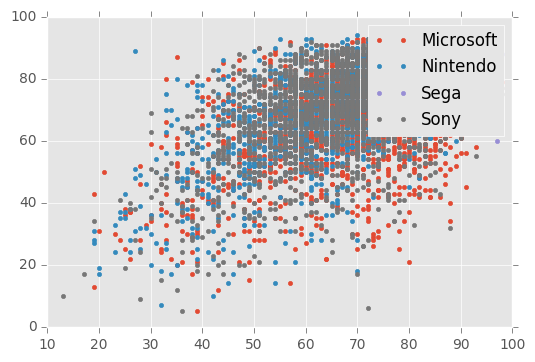

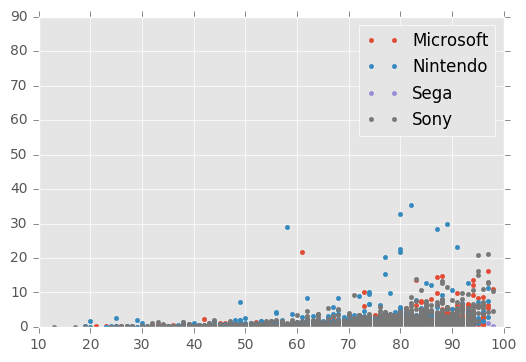

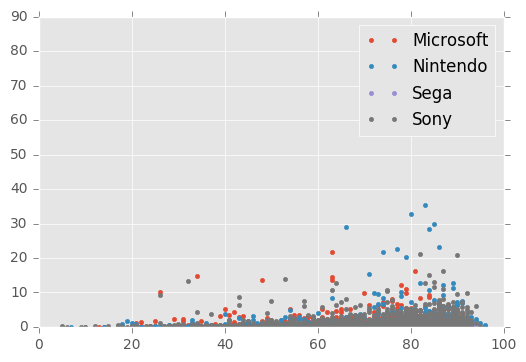

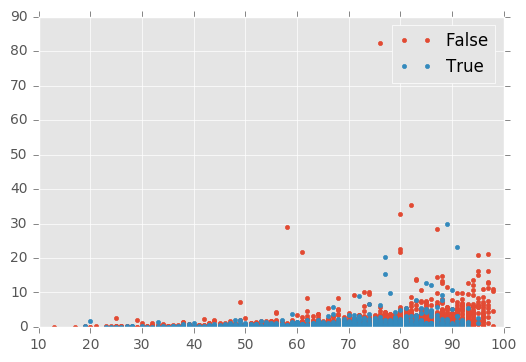

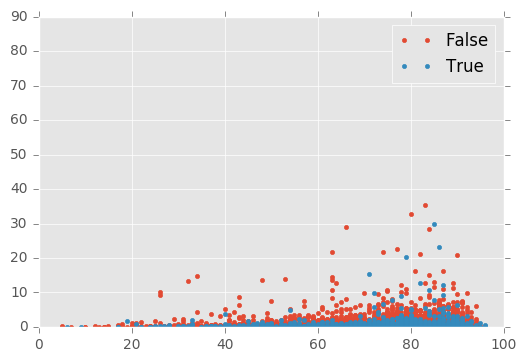

In [40]:
# Just for testing
groups = df1.groupby('Platform_Manufacturer')

# Plot
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.Critic_Score, group.User_Score, marker='.', linestyle='', label=name)
ax.legend()

plt.show()

# Just for testing
groups = df1.groupby('Platform_Manufacturer')

# Plot
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.Critic_Score, group.Global_Sales, marker='.', linestyle='', label=name)
ax.legend()

plt.show()

# Just for testing
groups = df1.groupby('Platform_Manufacturer')

# Plot
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.User_Score, group.Global_Sales, marker='.', linestyle='', label=name)
ax.legend()

plt.show()

# Just for testing
groups = df1.groupby('Portable')

# Plot
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.Critic_Score, group.Global_Sales, marker='.', linestyle='', label=name)
ax.legend()

plt.show()

# Just for testing
groups = df1.groupby('Portable')

# Plot
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.User_Score, group.Global_Sales, marker='.', linestyle='', label=name)
ax.legend()

plt.show()

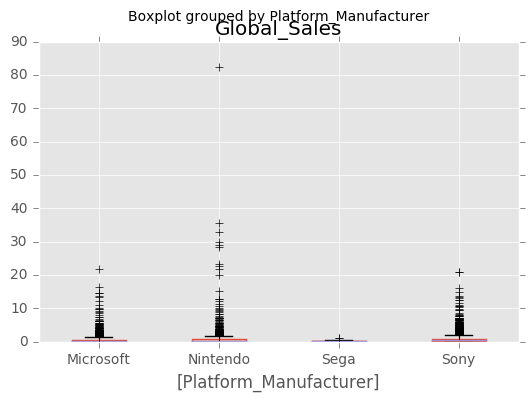

In [34]:
# Global_Sales
df1.boxplot(['Global_Sales'], by=['Platform_Manufacturer'])